In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [86]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from scipy.stats import pearsonr
from fnn.evaluation import *
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.notebook.utils import *
from torchdeepretina.datas import loadexpt

In [4]:
device = torch.device('cuda:0')
cfg = get_custom_cfg('bn_cnn_stack')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_030_loss_-2.77_pearson_0.6291_eval_loss_-29.18.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

BN_CNN_Stack(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Seq

In [5]:
test_data = DataLoader(TestDataset(cfg), batch_size=512)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 5, device, cfg)

In [69]:
with h5py.File('/home/TRAIN_DATA/15-10-07/naturalscene.h5', 'r') as f:
    target = f['test']['response']['firing_rate_10ms'][:5, 40:]
    single_trial = []
    for cell in ['cell01', 'cell02', 'cell03', 'cell04', 'cell05']:
        single_trial.append(f['test']['repeats'][cell])
    single_trial = np.stack(single_trial)
single_trial = np.swapaxes(single_trial,0,1)
single_trial = np.swapaxes(single_trial,1,2)[:,40:5996,:]
target = np.swapaxes(target,0,1)[:5956,:]

prediction correlation: 
 [[1.         0.41812848 0.73764551 0.38638577 0.27139948]
 [0.41812848 1.         0.61320255 0.50394363 0.25504505]
 [0.73764551 0.61320255 1.         0.40785126 0.32236908]
 [0.38638577 0.50394363 0.40785126 1.         0.28694018]
 [0.27139948 0.25504505 0.32236908 0.28694018 1.        ]]
trial-averaged correlation: 
 [[1.         0.1924971  0.51967268 0.29261007 0.21739408]
 [0.1924971  1.         0.29852532 0.27960452 0.14421011]
 [0.51967268 0.29852532 1.         0.24257533 0.2031594 ]
 [0.29261007 0.27960452 0.24257533 1.         0.2817152 ]
 [0.21739408 0.14421011 0.2031594  0.2817152  1.        ]]
single trial correlation: 
 [[1.         0.12576394 0.34438281 0.21857622 0.17052613]
 [0.12576394 1.         0.16655423 0.17993999 0.09052665]
 [0.34438281 0.16655423 1.         0.13613422 0.11973504]
 [0.21857622 0.17993999 0.13613422 1.         0.21250219]
 [0.17052613 0.09052665 0.11973504 0.21250219 1.        ]]
trial-averaged target prediction relative e

Text(0.5, 1.0, 'single trial target')

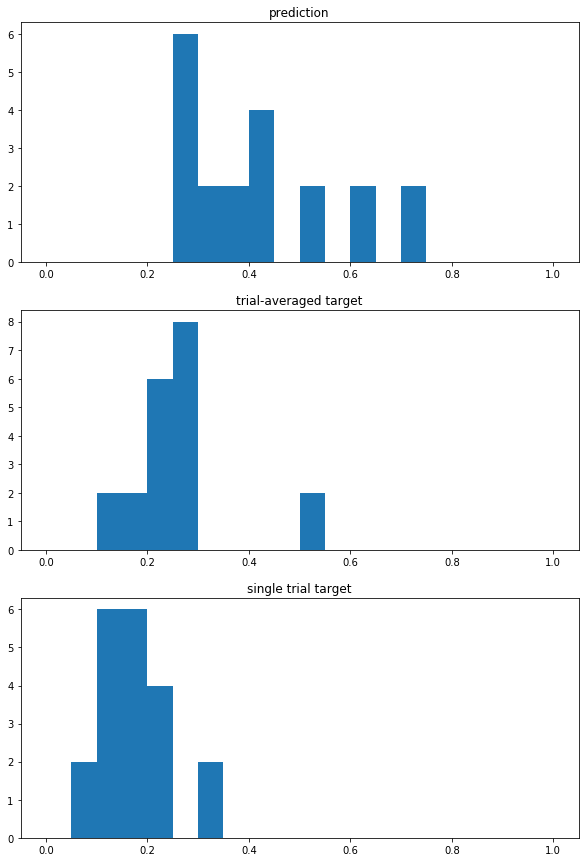

In [113]:
pred_corr, targ_corr, single_corr = correlation_matrix(pred, target, single_trial, binary=False)
print('prediction correlation: \n', pred_corr)
print('trial-averaged correlation: \n', targ_corr)
print('single trial correlation: \n', single_corr)
print('trial-averaged target prediction relative error: ', np.abs(targ_corr-pred_corr).sum()/targ_corr.sum())
print('single trial target prediction relative error: ', np.abs(single_corr-pred_corr).sum()/single_corr.sum())
fig,ax = plt.subplots(3,1,figsize=(10,15))
diagonal_idxs = [0, 6, 12, 18, 24]
ax[0].hist(np.delete(pred_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[0].set_title('prediction')
ax[1].hist(np.delete(targ_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[1].set_title('trial-averaged target')
ax[2].hist(np.delete(single_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[2].set_title('single trial target')

In [104]:
stim_corr = stimuli_corr_matrix(5, 5, single_trial)
noise_corr = single_corr - stim_corr
print('stimuli correlation: \n', stim_corr)
print('noise correlation: \n', noise_corr)

stimuli correlation: 
 [[0.67177597 0.11595256 0.2977213  0.22079329 0.15485661]
 [0.11595256 0.35368846 0.13764053 0.16512185 0.08163705]
 [0.2977213  0.13764053 0.34117301 0.14615804 0.1148277 ]
 [0.22079329 0.16512185 0.14615804 0.68809142 0.20296255]
 [0.15485661 0.08163705 0.1148277  0.20296255 0.61850253]]
noise correlation: 
 [[ 0.32822403  0.00981137  0.04666152 -0.00221707  0.01566952]
 [ 0.00981137  0.64631154  0.0289137   0.01481814  0.0088896 ]
 [ 0.04666152  0.0289137   0.65882699 -0.01002382  0.00490734]
 [-0.00221707  0.01481814 -0.01002382  0.31190858  0.00953964]
 [ 0.01566952  0.0088896   0.00490734  0.00953964  0.38149747]]


prediction correlation: 
 [[1.         0.34802537 0.54183846 0.32344996 0.24188172]
 [0.34802537 1.         0.4560578  0.3699236  0.21249664]
 [0.54183846 0.4560578  1.         0.34138642 0.25178278]
 [0.32344996 0.3699236  0.34138642 1.         0.23190375]
 [0.24188172 0.21249664 0.25178278 0.23190375 1.        ]]
trial-averaged correlation: 
 [[1.         0.1924971  0.51967268 0.29261007 0.21739408]
 [0.1924971  1.         0.29852532 0.27960452 0.14421011]
 [0.51967268 0.29852532 1.         0.24257533 0.2031594 ]
 [0.29261007 0.27960452 0.24257533 1.         0.2817152 ]
 [0.21739408 0.14421011 0.2031594  0.2817152  1.        ]]
single trial correlation: 
 [[1.         0.12576394 0.34438281 0.21857622 0.17052613]
 [0.12576394 1.         0.16655423 0.17993999 0.09052665]
 [0.34438281 0.16655423 1.         0.13613422 0.11973504]
 [0.21857622 0.17993999 0.13613422 1.         0.21250219]
 [0.17052613 0.09052665 0.11973504 0.21250219 1.        ]]
trial-averaged target prediction relative e

Text(0.5, 1.0, 'single trial target')

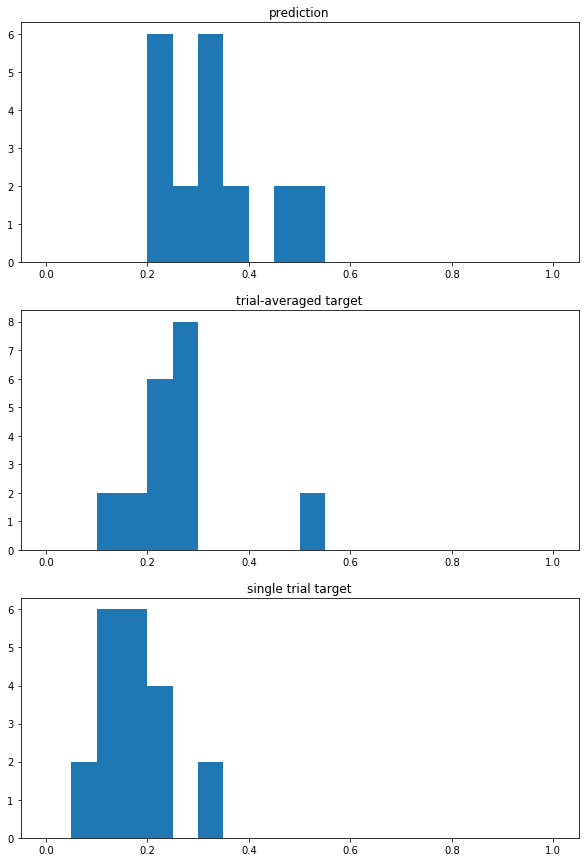

In [114]:
with torch.no_grad():
    val_pred = []
    val_targ = []
    for x,y in test_data:
        x = x.to(device)
        out = model.bipolar(x)
        out = model.amacrine(out)
        out = torch.poisson(model.ganglion(out))
        val_pred.append(out.detach().cpu().numpy())
        val_targ.append(y.detach().numpy())
    val_pred = np.concatenate(val_pred, axis=0)
    val_targ = np.concatenate(val_targ, axis=0)
#pred_corr, targ_corr = correlation_matrix(val_pred, val_targ, binary=True, thre=2)
pred_corr, targ_corr, single_corr = correlation_matrix(val_pred, target, single_trial, binary=False)
print('prediction correlation: \n', pred_corr)
print('trial-averaged correlation: \n', targ_corr)
print('single trial correlation: \n', single_corr)
print('trial-averaged target prediction relative error: ', np.abs(targ_corr-pred_corr).sum()/targ_corr.sum())
print('single trial target prediction relative error: ', np.abs(single_corr-pred_corr).sum()/single_corr.sum())
fig,ax = plt.subplots(3,1,figsize=(10,15))
diagonal_idxs = [0, 6, 12, 18, 24]
ax[0].hist(np.delete(pred_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[0].set_title('prediction')
ax[1].hist(np.delete(targ_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[1].set_title('trial-averaged target')
ax[2].hist(np.delete(single_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[2].set_title('single trial target')

prediction correlation: 
 [[1.         0.09193404 0.24350074 0.09368775 0.04254497]
 [0.09193404 1.         0.14045836 0.09550816 0.03778656]
 [0.24350074 0.14045836 1.         0.08991315 0.04446602]
 [0.09368775 0.09550816 0.08991315 1.         0.10632073]
 [0.04254497 0.03778656 0.04446602 0.10632073 1.        ]]
trial-averaged correlation: 
 [[1.         0.1924971  0.51967268 0.29261007 0.21739408]
 [0.1924971  1.         0.29852532 0.27960452 0.14421011]
 [0.51967268 0.29852532 1.         0.24257533 0.2031594 ]
 [0.29261007 0.27960452 0.24257533 1.         0.2817152 ]
 [0.21739408 0.14421011 0.2031594  0.2817152  1.        ]]
single trial correlation: 
 [[1.         0.12576394 0.34438281 0.21857622 0.17052613]
 [0.12576394 1.         0.16655423 0.17993999 0.09052665]
 [0.34438281 0.16655423 1.         0.13613422 0.11973504]
 [0.21857622 0.17993999 0.13613422 1.         0.21250219]
 [0.17052613 0.09052665 0.11973504 0.21250219 1.        ]]
trial-averaged target prediction relative e

Text(0.5, 1.0, 'single trial target')

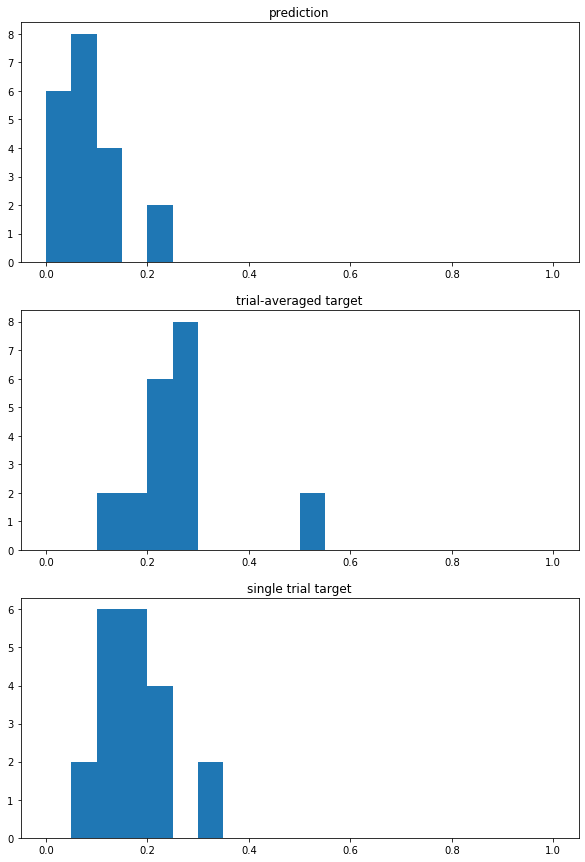

In [115]:
with torch.no_grad():
    val_pred = []
    val_targ = []
    for x,y in test_data:
        x = x.to(device)
        out = torch.poisson(model.bipolar(x))
        out = torch.poisson(model.amacrine(out))
        out = torch.poisson(model.ganglion(out))
        val_pred.append(out.detach().cpu().numpy())
        val_targ.append(y.detach().numpy())
    val_pred = np.concatenate(val_pred, axis=0)
    val_targ = np.concatenate(val_targ, axis=0)
#pred_corr, targ_corr = correlation_matrix(val_pred, val_targ, binary=True, thre=2)
pred_corr, targ_corr, single_corr = correlation_matrix(val_pred, target, single_trial, binary=False)
print('prediction correlation: \n', pred_corr)
print('trial-averaged correlation: \n', targ_corr)
print('single trial correlation: \n', single_corr)
print('trial-averaged target prediction relative error: ', np.abs(targ_corr-pred_corr).sum()/targ_corr.sum())
print('single trial target prediction relative error: ', np.abs(single_corr-pred_corr).sum()/single_corr.sum())
fig,ax = plt.subplots(3,1,figsize=(10,15))
diagonal_idxs = [0, 6, 12, 18, 24]
ax[0].hist(np.delete(pred_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[0].set_title('prediction')
ax[1].hist(np.delete(targ_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[1].set_title('trial-averaged target')
ax[2].hist(np.delete(single_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[2].set_title('single trial target')

In [123]:
pearsons = []
for cell in range(5):
    pearsons.append(pearsonr(val_pred[:,cell],target[:,cell])[0])
print('trial-averged vs prediction:', np.array(pearsons).mean())

trial-averged vs prediction: 0.21228164087716733


In [125]:
mean_r = []
for trial in range(5):
    pearsons = []
    for cell in range(5):
        pearsons.append(pearsonr(single_trial[trial,:,cell],target[:,cell])[0])
    mean_r.append(np.array(pearsons).mean())
print('trial-averged vs single-trial:', np.array(mean_r).mean())

trial-averged vs single-trial: 0.7875977724261742


In [126]:
mean_r = []
for trial in range(5):
    pearsons = []
    for cell in range(5):
        pearsons.append(pearsonr(single_trial[trial,:,cell],val_pred[:,cell])[0])
    mean_r.append(np.array(pearsons).mean())
print('single-trial vs prediction:', np.array(mean_r).mean())

single-trial vs prediction: 0.1720378012537985
